In [1]:
# Load the Dataset

import pandas as pd

df = pd.read_csv("financial_anomaly_data.csv")

df.head()


,Timestamp,TransactionID,AccountID,Amount,Merchant,TransactionType,Location
0,01-01-2023 08:00,TXN1127,ACC4,95071.92,MerchantH,Purchase,Tokyo
1,01-01-2023 08:01,TXN1639,ACC10,15607.89,MerchantH,Purchase,London
2,01-01-2023 08:02,TXN872,ACC8,65092.34,MerchantE,Withdrawal,London
3,01-01-2023 08:03,TXN1438,ACC6,87.87,MerchantE,Purchase,London
4,01-01-2023 08:04,TXN1338,ACC6,716.56,MerchantI,Purchase,Los Angeles


In [2]:
#  Basic Data
df.shape
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 217441 entries, 0 to 217440
Data columns (total 7 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Timestamp        216960 non-null  object 
 1   TransactionID    216960 non-null  object 
 2   AccountID        216960 non-null  object 
 3   Amount           216960 non-null  float64
 4   Merchant         216960 non-null  object 
 5   TransactionType  216960 non-null  object 
 6   Location         216960 non-null  object 
dtypes: float64(1), object(6)
memory usage: 11.6+ MB


In [3]:
# Missing Values
df.isnull().sum()


Timestamp          481
TransactionID      481
AccountID          481
Amount             481
Merchant           481
TransactionType    481
Location           481
dtype: int64

In [4]:
# Duplicate Records
df.duplicated().sum()

np.int64(480)

In [5]:
df[df.duplicated(subset="TransactionID")]



,Timestamp,TransactionID,AccountID,Amount,Merchant,TransactionType,Location
89,01-01-2023 09:29,TXN1021,ACC9,54801.71,MerchantE,Purchase,Los Angeles
102,01-01-2023 09:42,TXN1366,ACC4,23676.15,MerchantG,Purchase,Tokyo
125,01-01-2023 10:05,TXN1796,ACC14,87823.28,MerchantH,Withdrawal,London
147,01-01-2023 10:27,TXN1907,ACC15,10495.87,MerchantG,Purchase,London
154,01-01-2023 10:34,TXN1313,ACC5,10187.23,MerchantF,Withdrawal,London
...,...,...,...,...,...,...,...
217436,NaN,NaN,NaN,NaN,NaN,NaN,NaN
217437,NaN,NaN,NaN,NaN,NaN,NaN,NaN
217438,NaN,NaN,NaN,NaN,NaN,NaN,NaN
217439,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
# Invalid amounts

df[df["Amount"] <= 0]

,Timestamp,TransactionID,AccountID,Amount,Merchant,TransactionType,Location


In [7]:
df["Timestamp"].dtype


dtype('O')

In [8]:
df.dtypes

Timestamp           object
TransactionID       object
AccountID           object
Amount             float64
Merchant            object
TransactionType     object
Location            object
dtype: object

In [9]:
df["Timestamp"] = pd.to_datetime(df["Timestamp"], errors="coerce")


In [10]:
df["Timestamp"].dtype

dtype('<M8[ns]')

In [11]:
df["Timestamp"].isna().sum()


np.int64(131521)

In [12]:
# Transaction per day

daily_volume = df.groupby(df["Timestamp"].dt.date).size()
daily_volume.head()


Timestamp
2023-01-01     960
2023-01-02    1440
2023-01-03    1440
2023-01-04    1440
2023-01-05    1440
dtype: int64

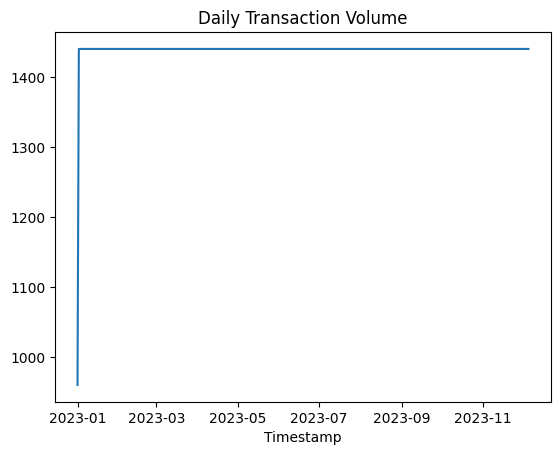

In [13]:
import matplotlib.pyplot as plt

daily_volume.plot(title="Daily Transaction Volume")
plt.show()

In [14]:
# Create Daily Volume
df["date"] = df["Timestamp"].dt.floor("D")

daily_volume = df.groupby("date").size().reset_index(name="txn_count")
daily_volume.head()


,date,txn_count
0,2023-01-01,960
1,2023-01-02,1440
2,2023-01-03,1440
3,2023-01-04,1440
4,2023-01-05,1440


In [15]:
#understand normal volume
daily_volume["txn_count"].describe()

count      60.000000
mean     1432.000000
std        61.967734
min       960.000000
25%      1440.000000
50%      1440.000000
75%      1440.000000
max      1440.000000
Name: txn_count, dtype: float64

In [16]:
# Detect Anomalies (Statistical, Simple & Powerful)
# Z-Score Method (Industry Standard)
mean = daily_volume["txn_count"].mean()
std = daily_volume["txn_count"].std()

daily_volume["z_score"] = (daily_volume["txn_count"] - mean) / std

daily_volume["volume_anomaly"] = daily_volume["z_score"].abs() > 3

In [17]:
# Inspect Anomalies
daily_volume[daily_volume["volume_anomaly"] == True]

,date,txn_count,z_score,volume_anomaly
0,2023-01-01,960,-7.616867,True


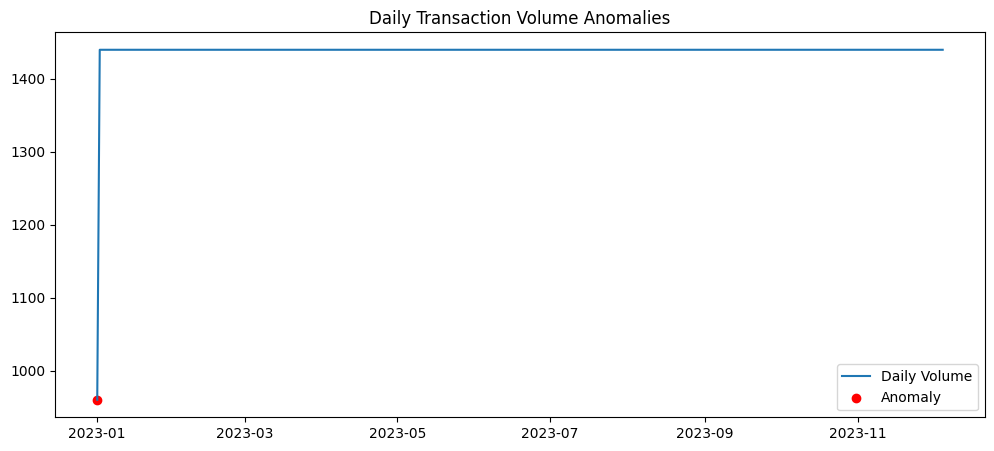

In [18]:
# Visualize (Very Important)
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(daily_volume["date"], daily_volume["txn_count"], label="Daily Volume")
plt.scatter(
    daily_volume.loc[daily_volume["volume_anomaly"], "date"],
    daily_volume.loc[daily_volume["volume_anomaly"], "txn_count"],
    color="red",
    label="Anomaly"
)
plt.legend()
plt.title("Daily Transaction Volume Anomalies")
plt.show()

In [19]:
# Understand Amount Distribution
df["Amount"].describe(percentiles=[0.95, 0.99])

count    216960.000000
mean      50090.025108
std       29097.905016
min          10.510000
50%       50183.980000
95%       94954.848500
99%       99018.522900
max      978942.260000
Name: Amount, dtype: float64

In [20]:
# Detect Amount Anomalies (IQR Method)

# This is robust and widely used

Q1 = df["Amount"].quantile(0.25)
Q3 = df["Amount"].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df["amount_anomaly"] = (df["Amount"] < lower_bound) | (df["Amount"] >upper_bound)

In [21]:
# Inspect Suspicious Transactions
df[df["amount_anomaly"] == True].head()

,Timestamp,TransactionID,AccountID,Amount,Merchant,TransactionType,Location,date,amount_anomaly
2775,2023-03-01 06:15:00,TXN1049,ACC14,978942.26,MerchantJ,Transfer,New York,2023-03-01,True
3448,2023-03-01 17:28:00,TXN827,ACC12,712076.97,MerchantA,Withdrawal,Tokyo,2023-03-01,True
3453,2023-03-01 17:33:00,TXN1690,ACC8,489492.30,MerchantF,Purchase,Tokyo,2023-03-01,True
4148,2023-04-01 05:08:00,TXN625,ACC1,187344.37,MerchantD,Purchase,San Francisco,2023-04-01,True
4194,2023-04-01 05:54:00,TXN667,ACC3,272990.11,MerchantE,Transfer,Los Angeles,2023-04-01,True


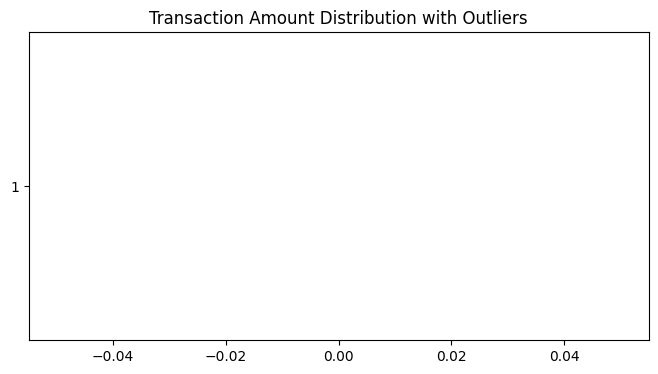

In [22]:
# Visualize Amount Anomalies
plt.figure(figsize=(8,4))
plt.boxplot(df["Amount"], vert=False)
plt.title("Transaction Amount Distribution with Outliers")
plt.show()

In [23]:
# CHECK AMOUNT COLUMN PROPERLY
df["Amount"].describe()


count    216960.000000
mean      50090.025108
std       29097.905016
min          10.510000
25%       25061.242500
50%       50183.980000
75%       75080.460000
max      978942.260000
Name: Amount, dtype: float64

In [24]:
df["Amount"].dtype


dtype('float64')

In [25]:
df["Amount"].isna().sum()


np.int64(481)

In [26]:
(df["Amount"] == 0).sum()


np.int64(0)

In [27]:
# FIX AMOUNT DATA TYPE (CRITICAL)


df["Amount"] = pd.to_numeric(df["Amount"], errors="coerce")

In [28]:
df["Amount"].dtype


dtype('float64')

In [29]:
df_clean = df[df["Amount"] > 0]


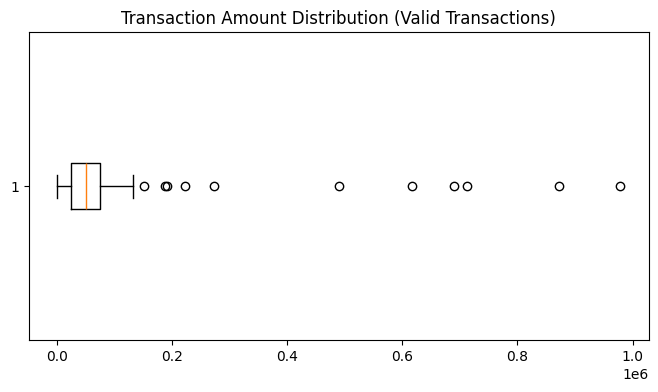

In [30]:
# PLOT AGAIN (THIS WILL FIX IT)
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plt.boxplot(df_clean["Amount"], vert=False)
plt.title("Transaction Amount Distribution (Valid Transactions)")
plt.show()

In [31]:
# ACCOUNT-LEVEL BEHAVIOR PROFILING

# We now aggregate per AccountID.

account_stats = df_clean.groupby("AccountID").agg(
    total_transactions=("TransactionID", "count"),
    total_amount=("Amount", "sum"),
    avg_amount=("Amount", "mean"),
    max_amount=("Amount", "max")
).reset_index()

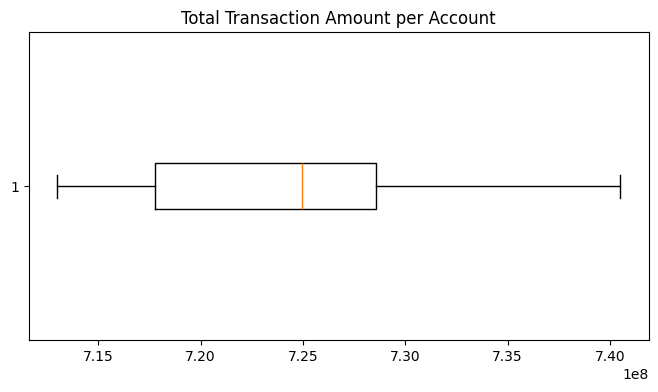

In [32]:
# Visualize High-Risk Accounts (Core Insight)
plt.figure(figsize=(8,4))
plt.boxplot(account_stats["total_amount"], vert=False)
plt.title("Total Transaction Amount per Account")
plt.show()

In [33]:
# FLAG ANOMALOUS ACCOUNTS (STATISTICAL RULE)

# We now apply IQR-based anomaly detection


Q1 = account_stats["total_amount"].quantile(0.25)
Q3 = account_stats["total_amount"].quantile(0.75)
IQR = Q3 - Q1

threshold = Q3 + 1.5 * IQR

account_stats["is_anomaly"] = account_stats["total_amount"] > threshold

In [34]:
# See Flagged Accounts
anomalous_accounts = account_stats[account_stats["is_anomaly"]]
anomalous_accounts.head()

,AccountID,total_transactions,total_amount,avg_amount,max_amount,is_anomaly


In [35]:
# Select Features

# We do not feed raw transactions.
# We feed account behavior features.

features = account_stats[
    ["total_transactions", "total_amount", "avg_amount", "max_amount"]]

In [36]:
# Scale Features (MANDATORY)
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

In [37]:
# Train Isolation Forest
from sklearn.ensemble import IsolationForest

iso_forest = IsolationForest(
    n_estimators=200,
    contamination=0.03,   # assume ~3% abnormal accounts
    random_state=42
)

account_stats["ml_anomaly"] = iso_forest.fit_predict(X_scaled)

In [38]:
# Convert to Readable Flag
account_stats["ml_anomaly"] = account_stats["ml_anomaly"].map(
    {1: "Normal", -1: "Anomalous"}
)

In [39]:
# ANALYZE ML RESULTS
account_stats["ml_anomaly"].value_counts()

ml_anomaly
Normal       14
Anomalous     1
Name: count, dtype: int64

In [40]:
# INVESTIGATE THE ANOMALOUS ACCOUNT (CRITICAL)

# Now we profile the risky account.

risky_account = account_stats[account_stats["ml_anomaly"] == "Anomalous"]
risky_account

,AccountID,total_transactions,total_amount,avg_amount,max_amount,is_anomaly,ml_anomaly
6,ACC15,14701,740517222.6,50371.894606,99992.28,False,Anomalous


In [41]:
account_stats[account_stats["ml_anomaly"] == "Anomalous"].head()

,AccountID,total_transactions,total_amount,avg_amount,max_amount,is_anomaly,ml_anomaly
6,ACC15,14701,740517222.6,50371.894606,99992.28,False,Anomalous


In [42]:
# COMPARE AGAINST NORMAL ACCOUNTS
account_stats.groupby("ml_anomaly")[[
    "total_transactions",
    "total_amount",
    "avg_amount",
    "max_amount"
]].mean()

,total_transactions,total_amount,avg_amount,max_amount
ml_anomaly,,,,
Anomalous,14701.000000,7.405172e+08,50371.894606,99992.280000
Normal,14447.071429,7.233582e+08,50069.535305,338458.629286


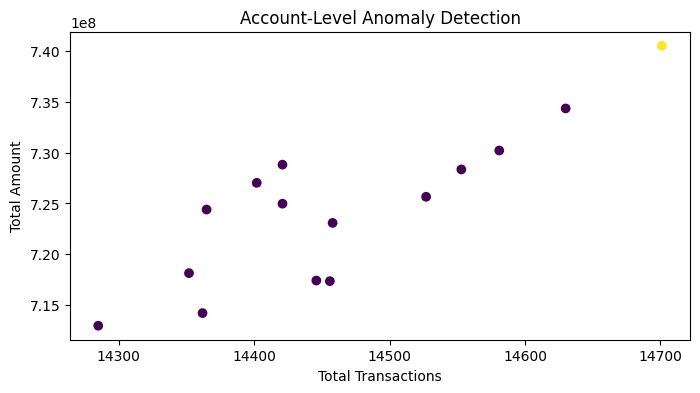

In [43]:
# VISUAL VALIDATION
plt.figure(figsize=(8,4))
plt.scatter(
    account_stats["total_transactions"],
    account_stats["total_amount"],
    c=(account_stats["ml_anomaly"] == "Anomalous")
)
plt.xlabel("Total Transactions")
plt.ylabel("Total Amount")
plt.title("Account-Level Anomaly Detection")
plt.show()

In [44]:
account_stats["anomaly_score"] = iso_forest.decision_function(X_scaled)


In [45]:
account_stats.sort_values("anomaly_score").head()


,AccountID,total_transactions,total_amount,avg_amount,max_amount,is_anomaly,ml_anomaly,anomaly_score
6,ACC15,14701,7.405172e+08,50371.894606,99992.28,False,Anomalous,-0.014443
10,ACC5,14630,7.343486e+08,50194.706156,873004.79,False,Normal,0.019945
8,ACC3,14285,7.129758e+08,49910.799135,272990.11,False,Normal,0.033290
5,ACC14,14458,7.230894e+08,50013.096792,978942.26,False,Normal,0.048251
13,ACC8,14402,7.270316e+08,50481.295047,616155.70,False,Normal,0.086066


In [46]:
# Ensure Timestamp is Datetime
df_clean["Timestamp"] = pd.to_datetime(df_clean["Timestamp"])

C:\Users\aniru\AppData\Local\Temp\ipykernel_6716\2557500091.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean["Timestamp"] = pd.to_datetime(df_clean["Timestamp"])


In [47]:
# Transactions per Account per Day
daily_account_activity = (
    df_clean
    .groupby([df_clean["AccountID"], df_clean["Timestamp"].dt.date])
    .size()
    .reset_index(name="tx_per_day")
)

In [48]:
# Detect Burst Using IQR
Q1 = daily_account_activity["tx_per_day"].quantile(0.25)
Q3 = daily_account_activity["tx_per_day"].quantile(0.75)
IQR = Q3 - Q1

burst_threshold = Q3 + 1.5 * IQR

daily_account_activity["burst_flag"] = (
    daily_account_activity["tx_per_day"] > burst_threshold
)

In [49]:
# Extract Burst Accounts
burst_accounts = daily_account_activity[
    daily_account_activity["burst_flag"]
]["AccountID"].unique()

In [50]:
# Merchant Aggregation
merchant_stats = df_clean.groupby("Merchant").agg(
    total_tx=("TransactionID", "count"),
    total_amount=("Amount", "sum"),
    avg_amount=("Amount", "mean")
).reset_index()

In [51]:
# Detect High-Risk Merchants (IQR)
Q1 = merchant_stats["total_amount"].quantile(0.25)
Q3 = merchant_stats["total_amount"].quantile(0.75)
IQR = Q3 - Q1

merchant_threshold = Q3 + 1.5 * IQR

merchant_stats["merchant_anomaly"] = (
    merchant_stats["total_amount"] > merchant_threshold
)

In [52]:
# View Suspicious Merchants
merchant_stats[merchant_stats["merchant_anomaly"]]

,Merchant,total_tx,total_amount,avg_amount,merchant_anomaly


In [53]:
# Dashboard

# Merge All Risk Signals
account_stats["burst_flag"] = account_stats["AccountID"].isin(burst_accounts)

In [54]:
# Final Risk Scoring (Rule-Based)
account_stats["risk_score"] = (
    (account_stats["ml_anomaly"] == "Anomalous").astype(int) * 2 +
    account_stats["burst_flag"].astype(int)
)

In [55]:
# Risk Category
def risk_label(score):
    if score == 3:
        return "Critical"
    elif score == 2:
        return "High"
    elif score == 1:
        return "Medium"
    else:
        return "Low"

account_stats["risk_level"] = account_stats["risk_score"].apply(risk_label)

In [56]:
# This Table = Your Dashboard Backbone
account_stats[[
    "AccountID",
    "total_transactions",
    "total_amount",
    "max_amount",
    "ml_anomaly",
    "burst_flag",
    "risk_level"
]]

,AccountID,total_transactions,total_amount,max_amount,ml_anomaly,burst_flag,risk_level
0,ACC1,14365,7.244058e+08,187344.37,Normal,False,Low
1,ACC10,14362,7.142212e+08,99986.15,Normal,False,Low
2,ACC11,14446,7.174198e+08,151020.55,Normal,False,Low
3,ACC12,14421,7.249790e+08,712076.97,Normal,False,Low
4,ACC13,14421,7.288201e+08,99996.00,Normal,False,Low
5,ACC14,14458,7.230894e+08,978942.26,Normal,False,Low
6,ACC15,14701,7.405172e+08,99992.28,Anomalous,False,High
7,ACC2,14553,7.283480e+08,191561.95,Normal,False,Low
8,ACC3,14285,7.129758e+08,272990.11,Normal,False,Low
9,ACC4,14456,7.173613e+08,223542.64,Normal,False,Low


In [59]:
import pandas as pd
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
import joblib

# Load training data
df = pd.read_csv(r"C:\Users\aniru\Downloads\financialanomalydetection\financial_anomaly_data.csv")

# Feature engineering
account_stats = df.groupby("AccountID").agg(
    total_transactions=("TransactionID", "count"),
    total_amount=("Amount", "sum"),
    avg_amount=("Amount", "mean"),
    max_amount=("Amount", "max")
).reset_index()

X = account_stats[["total_transactions", "total_amount", "avg_amount", "max_amount"]]

# Scale
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train model
model = IsolationForest(
    n_estimators=200,
    contamination=0.05,
    random_state=42
)
model.fit(X_scaled)

#  SAVE ARTIFACTS (THIS CREATES PKLs)
joblib.dump(model, "isolation_forest.pkl")
joblib.dump(scaler, "scaler.pkl")

print(" Model and scaler saved successfully")


 Model and scaler saved successfully


In [ ]:
%%writefile requirements.txt
pandas
numpy
scikit-learn
joblib
streamlit


Writing requirements.txt


In [63]:
def detect_anomalies(file):
    df = pd.read_csv(file.name)

    required_cols = [
        "Timestamp", "TransactionID", "AccountID",
        "Amount", "Merchant", "TransactionType", "Location"
    ]

    # If columns missing → return EMPTY dataframe with message column
    if not all(col in df.columns for col in required_cols):
        return pd.DataFrame({
            "Error": ["Uploaded CSV does not contain required columns"]
        })

    # Aggregate
    account_stats = df.groupby("AccountID").agg(
        total_transactions=("TransactionID", "count"),
        total_amount=("Amount", "sum"),
        avg_amount=("Amount", "mean"),
        max_amount=("Amount", "max")
    ).reset_index()

    # Scale + predict
    X = scaler.transform(
        account_stats[[
            "total_transactions",
            "total_amount",
            "avg_amount",
            "max_amount"
        ]]
    )

    preds = model.predict(X)
    account_stats["Anomaly"] = [
        "Anomalous" if p == -1 else "Normal" for p in preds
    ]

    return account_stats


In [64]:
import gradio as gr
import pandas as pd
import joblib

import os
print(os.getcwd())
print(os.listdir())


# Load model artifacts
model = joblib.load("isolation_forest.pkl")
scaler = joblib.load("scaler.pkl")

def detect_anomalies(file):
    df = pd.read_csv(file.name)

    # Basic validation
    required_cols = [
        "Timestamp", "TransactionID", "AccountID",
        "Amount", "Merchant", "TransactionType", "Location"
    ]
    if not all(col in df.columns for col in required_cols):
        return " Uploaded CSV does not contain required columns."

    # Aggregate to account level
    account_stats = df.groupby("AccountID").agg(
        total_transactions=("TransactionID", "count"),
        total_amount=("Amount", "sum"),
        avg_amount=("Amount", "mean"),
        max_amount=("Amount", "max")
    ).reset_index()

    # Scale + predict
    X = scaler.transform(
        account_stats[["total_transactions", "total_amount", "avg_amount", "max_amount"]]
    )

    preds = model.predict(X)
    account_stats["Anomaly"] = ["Anomalous" if p == -1 else "Normal" for p in preds]

    return account_stats

# Gradio UI
app = gr.Interface(
    fn=detect_anomalies,
    inputs=gr.File(label="Upload Transaction CSV"),
    outputs=gr.Dataframe(label="Account-Level Anomaly Results"),
    title=" Financial Anomaly Detection System",
    description="Upload transaction-level financial data to detect anomalous accounts using ML."
)

if __name__ == "__main__":
    app.launch()


c:\Users\aniru\Downloads\financialanomalydetection
['.gradio', 'Data_Quality_Monitoring&Anomaly_Detection.ipynb', 'financial_anomaly_data.csv', 'isolation_forest.pkl', 'requirements.txt', 'scaler.pkl']
* Running on local URL:  http://127.0.0.1:7861
* To create a public link, set `share=True` in `launch()`.


In [ ]:
! pip install gradio pandas scikit-learn joblib matplotlib
